In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_add_pool, global_mean_pool
from torch_geometric.data import Data, Batch # Batch is implicitly used by DataLoader
# Assuming your FPGAGraphDataset and create_dataloaders functions are in a file, e.g., dataset_utils.py
# from dataset_utils import FPGAGraphDataset, create_dataloaders



class FPGA_GNN(nn.Module):
    def __init__(self, node_feature_dim, num_targets, hidden_dim=128, num_gnn_layers=2, mlp_hidden_dim=64, dropout_rate=0.2):
        """
        GraphSAGE based GNN for FPGA resource and latency prediction.

        Args:
            node_feature_dim (int): Dimensionality of node features.
            num_targets (int): Number of target values to predict (6 in your case).
            hidden_dim (int): Hidden dimension for SAGEConv layers.
            num_gnn_layers (int): Number of SAGEConv layers.
            mlp_hidden_dim (int): Hidden dimension for the MLP head.
            dropout_rate (float): Dropout rate.
        """
        super(FPGA_GNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_gnn_layers = num_gnn_layers
        self.dropout_rate = dropout_rate

        self.convs = nn.ModuleList()
        # Initial SAGEConv layer
        self.convs.append(SAGEConv(node_feature_dim, hidden_dim, aggr='sum'))
        
        # Additional SAGEConv layers
        for _ in range(num_gnn_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr='sum'))

        # MLP head for graph-level regression
        # The input to the MLP will be the pooled graph embedding + the strategy feature
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + 1, mlp_hidden_dim), # +1 for the strategy feature
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(mlp_hidden_dim, mlp_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(mlp_hidden_dim // 2, num_targets)
        )
        
        # Optional: Batch normalization for GNN layers (can sometimes help)
        # self.bns = nn.ModuleList()
        # for _ in range(num_gnn_layers):
        #     self.bns.append(nn.BatchNorm1d(hidden_dim))

    def forward(self, data):
        """
        Forward pass of the GNN.

        Args:
            data (torch_geometric.data.Batch or torch_geometric.data.Data):
                A batch of graph data containing:
                - data.x: Node features [num_nodes_in_batch, node_feature_dim]
                - data.edge_index: Edge connectivity [2, num_edges_in_batch]
                - data.batch: Batch assignment vector [num_nodes_in_batch]
                - data.strategy: Global strategy feature [batch_size, 1]
        
        Returns:
            torch.Tensor: Predicted target values [batch_size, num_targets]
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Node embeddings through SAGEConv layers
        for i in range(self.num_gnn_layers):
            x = self.convs[i](x, edge_index)
            # x = self.bns[i](x) # If using BatchNorm
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Global pooling (sum aggregation as discussed)
        # Alternatives: global_mean_pool, global_max_pool
        graph_embedding = global_add_pool(x, batch) # [batch_size, hidden_dim]
        
        # Concatenate global strategy feature
        # data.strategy should have shape [batch_size, 1]
        strategy_feature = data.strategy
        if strategy_feature.dim() == 1: # Ensure it's [batch_size, 1]
            strategy_feature = strategy_feature.unsqueeze(1)
            
        # Verify batch sizes match before concatenation
        if strategy_feature.shape[0] != graph_embedding.shape[0]:
             # This can happen if the last batch is smaller and drop_last=False in DataLoader
             # For FPGAGraphDataset, strategy is [1,1] for single Data, and collated to [batch_size,1,1]
             # then accessed via batch.strategy, resulting in [batch_size, 1]
             # However, your FPGAGraphDataset's get method shapes strategy to [1,1],
             # so when batched it will be [batch_size, 1, 1]. Need to squeeze.
            if strategy_feature.dim() == 3 and strategy_feature.shape[2] == 1:
                strategy_feature = strategy_feature.squeeze(-1) # [batch_size, 1]
            
            # If after squeeze, it's still not matching, there might be an issue.
            # This check is mostly a safeguard.
            if strategy_feature.shape[0] != graph_embedding.shape[0]:
                raise ValueError(f"Batch size mismatch between graph embedding ({graph_embedding.shape[0]}) and strategy feature ({strategy_feature.shape[0]})")

        combined_embedding = torch.cat([graph_embedding, strategy_feature], dim=1) # [batch_size, hidden_dim + 1]
        
        # MLP for prediction
        output = self.mlp(combined_embedding) # [batch_size, num_targets]
        
        return output

In [2]:
# generate_plots.py
# Code to generate plots after training your GNN model

import torch
import numpy as np
from wa_hls4ml_models.utils.plot import plot_loss, plot_box_plots_symlog, plot_results_simplified

def generate_all_plots(model, dataset, train_loader, test_loader, train_losses, val_losses, 
                      output_dir="results", device=None):
    """
    Generate all plots for the trained GNN model.
    
    Args:
        model: Trained GNN model
        dataset: Dataset object with denormalization methods
        train_loader: Training data loader
        test_loader: Test data loader  
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        output_dir: Directory to save plots
        device: Device to run inference on
    """
    
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Define output feature names based on your model
    output_features = ['CYCLES', 'II', 'FF', 'LUT', 'BRAM', 'DSP']
    
    print("Generating plots...")
    
    # 1. Plot training curves
    print("1. Plotting training curves...")
    plot_loss(train_losses, val_losses, outdir=f"{output_dir}/plots")
    
    # 2. Get test predictions for other plots
    print("2. Getting test predictions...")
    model.eval()
    test_predictions = []
    test_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            predictions = model(batch)
            targets = batch.y.squeeze(1)
            
            test_predictions.append(predictions.cpu())
            test_targets.append(targets.cpu())
    
    # Concatenate and denormalize for plotting
    test_predictions = torch.cat(test_predictions, dim=0)
    test_targets = torch.cat(test_targets, dim=0)
    
    # Denormalize for interpretable plots
    test_predictions_denorm = dataset.denormalize_labels(test_predictions).numpy()
    test_targets_denorm = dataset.denormalize_labels(test_targets).numpy()
    
    print(f"Test set size: {test_predictions_denorm.shape[0]} samples")
    print(f"Number of targets: {test_predictions_denorm.shape[1]}")
    
    # 3. Plot box plots with prediction errors
    print("3. Plotting box plots...")
    plot_box_plots_symlog(test_predictions_denorm, test_targets_denorm, output_dir)
    
    # 4. Plot scatter plots (actual vs predicted)
    print("4. Plotting scatter plots...")
    plot_results_simplified(
        name="GNN_Test_Results",
        mpl_plots=True,  # Generate matplotlib plots
        y_test=test_targets_denorm,
        y_pred=test_predictions_denorm,
        output_features=output_features,
        folder_name=output_dir
    )
    
    print(f"All plots saved to {output_dir}/plots/")
    
    # Print some summary statistics
    print("\nSummary Statistics:")
    print("="*50)
    for i, feature in enumerate(output_features):
        mae = np.mean(np.abs(test_targets_denorm[:, i] - test_predictions_denorm[:, i]))
        mse = np.mean((test_targets_denorm[:, i] - test_predictions_denorm[:, i])**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((test_targets_denorm[:, i] - test_predictions_denorm[:, i]) / 
                             (test_targets_denorm[:, i] + 1e-8))) * 100
        
        print(f"{feature}:")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print()


Using device: cpu
Creating DataLoaders...
Loading features from: May_15_processed/combined_features.npy
Loading labels from: May_15_processed/combined_labels.npy
Loaded dataset with 448912 samples
Attempting to load normalization stats from: May_15_processed/calculated_TrainingOnly_normalization_stats.npy
Loaded statistics for features: ['d_in1', 'd_in2', 'd_in3', 'd_out1', 'd_out2', 'd_out3', 'prec', 'rf', 'filters', 'kernel_size', 'stride', 'pooling']
Successfully loaded normalization stats.
Dataset split: 314238 train, 67337 validation, 67337 test samples.
Loading features from: May_15_processed/combined_features.npy


/home/users/ddemler/miniconda3/envs/hls4ml-custom2/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Loading labels from: May_15_processed/combined_labels.npy
Using provided normalization statistics.
Processed node feature dimension will be: 32
DataLoaders created. Node feature dimension: 32, Num targets: 6
Train loader: 153 batches, Val loader: 33 batches, Test loader: 33 batches

Label normalization statistics:
Label means: tensor([9.1530e+04, 2.0177e+04, 2.5279e+04, 2.2979e+01, 4.4765e+00, 8.8730e+04])
Label stds: tensor([8.1288e+05, 2.0204e+04, 1.6671e+04, 2.5179e+01, 5.7079e+00, 8.1316e+05])

Model architecture:
FPGA_GNN(
  (convs): ModuleList(
    (0): SAGEConv(32, 128, aggr=sum)
    (1-2): 2 x SAGEConv(128, 128, aggr=sum)
  )
  (mlp): Sequential(
    (0): Linear(in_features=129, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)

Starting training for 1 epochs...


Training: 100%|██████████| 153/153 [02:35<00:00,  1.02s/it]


Epoch   0: Train Loss = 5.401309e-01, Val Loss = 2.671304e-01

Loaded best model with validation loss: 2.671304e-01

FINAL EVALUATION

Training Set Metrics (denormalized):
  MAE: 23847.2148
  MSE: 107117453312.0000
  RMSE: 327288.0312
  MAPE: 448356736.0000

Validation Set Metrics (denormalized):
  MAE: 23859.6191
  MSE: 101610774528.0000
  RMSE: 318764.4688
  MAPE: 449205344.0000

Test Set Metrics (denormalized):
  MAE: 23970.6758
  MSE: 112408043520.0000
  RMSE: 335273.0938
  MAPE: 448045536.0000


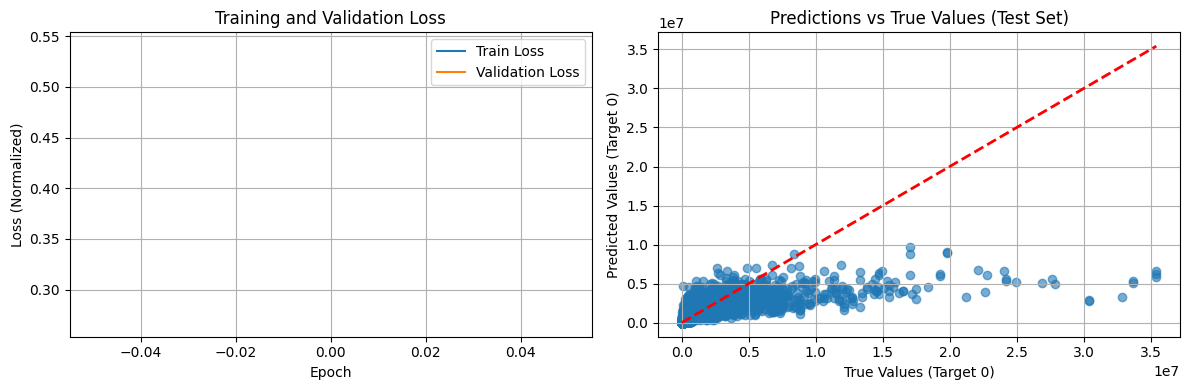


Model saved to: May_15_processed/best_fpga_gnn_model.pth
Loading features from: May_15_processed/combined_features.npy
Loading labels from: May_15_processed/combined_labels.npy
Loaded dataset with 448912 samples
Attempting to load normalization stats from: May_15_processed/calculated_TrainingOnly_normalization_stats.npy
Loaded statistics for features: ['d_in1', 'd_in2', 'd_in3', 'd_out1', 'd_out2', 'd_out3', 'prec', 'rf', 'filters', 'kernel_size', 'stride', 'pooling']
Successfully loaded normalization stats.
Dataset split: 314238 train, 67337 validation, 67337 test samples.
Loading features from: May_15_processed/combined_features.npy
Loading labels from: May_15_processed/combined_labels.npy
Using provided normalization statistics.
Processed node feature dimension will be: 32
Generating plots...
1. Plotting training curves...
2. Getting test predictions...
Test set size: 67337 samples
Number of targets: 6
3. Plotting box plots...
4. Plotting scatter plots...
All plots saved to results

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_add_pool, global_mean_pool
from torch_geometric.data import Data, Batch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from Dataset import create_dataloaders

# Configuration
FEATURES_PATH = 'May_15_processed/combined_features.npy'
LABELS_PATH = 'May_15_processed/combined_labels.npy'
# Path to load pre-calculated stats (if available) or save newly calculated ones
STATS_PATH = 'May_15_processed/calculated_TrainingOnly_normalization_stats.npy'

BATCH_SIZE = 2048
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1
WEIGHT_DECAY = 1e-5 # For L2 regularization

# GNN Hyperparameters
GNN_HIDDEN_DIM = 128
GNN_NUM_LAYERS = 3
MLP_HIDDEN_DIM = 64
DROPOUT_RATE = 0.3

def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(batch)
        loss = criterion(predictions, batch.y.squeeze(1))  # Remove extra dimension from y
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def evaluate(model, data_loader, criterion, device, dataset, denormalize=True):
    """Evaluate the model on given data loader."""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Forward pass
            predictions = model(batch)
            targets = batch.y.squeeze(1)
            
            # Calculate loss on normalized values
            loss = criterion(predictions, targets)
            total_loss += loss.item()
            num_batches += 1
            
            # Store predictions and targets
            all_predictions.append(predictions.cpu())
            all_targets.append(targets.cpu())
    
    # Concatenate all predictions and targets
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Denormalize if requested (for interpretable metrics)
    if denormalize:
        all_predictions = dataset.denormalize_labels(all_predictions)
        all_targets = dataset.denormalize_labels(all_targets)
    
    avg_loss = total_loss / num_batches
    return avg_loss, all_predictions, all_targets

def calculate_metrics(predictions, targets):
    """Calculate various regression metrics."""
    # Mean Absolute Error
    mae = torch.mean(torch.abs(predictions - targets))
    
    # Mean Squared Error
    mse = torch.mean((predictions - targets) ** 2)
    
    # Root Mean Squared Error
    rmse = torch.sqrt(mse)
    
    # Mean Absolute Percentage Error
    mape = torch.mean(torch.abs((targets - predictions) / (targets + 1e-8))) * 100
    
    return {
        'MAE': mae.item(),
        'MSE': mse.item(),
        'RMSE': rmse.item(),
        'MAPE': mape.item()
    }

def train_gnn():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 1. Create DataLoaders - NOTE THE UPDATED UNPACKING
    print("Creating DataLoaders...")
    train_loader, val_loader, test_loader, dataset, node_feature_dim, num_targets = create_dataloaders(
        feature_path=FEATURES_PATH,
        labels_path=LABELS_PATH,
        # stats_load_path=None, # Load if exists
        stats_load_path=STATS_PATH, # Load if exists
        stats_save_path=STATS_PATH, # Save if calculated on training set
        batch_size=BATCH_SIZE,
        train_val_test_split=(0.7, 0.15, 0.15),
        random_seed=42,
        num_workers=5,
        pin_memory=True if device.type == 'cuda' else False
    )
    print(f"DataLoaders created. Node feature dimension: {node_feature_dim}, Num targets: {num_targets}")
    print(f"Train loader: {len(train_loader)} batches, Val loader: {len(val_loader) if val_loader else 0} batches, Test loader: {len(test_loader) if test_loader else 0} batches")

    # Print normalization statistics for reference
    print(f"\nLabel normalization statistics:")
    print(f"Label means: {dataset.label_means}")
    print(f"Label stds: {dataset.label_stds}")

    # 2. Initialize Model, Optimizer, and Loss Function
    model = FPGA_GNN(
        node_feature_dim=node_feature_dim,
        num_targets=num_targets,
        hidden_dim=GNN_HIDDEN_DIM,
        num_gnn_layers=GNN_NUM_LAYERS,
        mlp_hidden_dim=MLP_HIDDEN_DIM,
        dropout_rate=DROPOUT_RATE
    ).to(device)
    print("\nModel architecture:")
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.MSELoss() # MSE on normalized targets

    # Learning rate scheduler (optional)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )

    # 3. Training Loop
    print(f"\nStarting training for {NUM_EPOCHS} epochs...")
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 20

    for epoch in range(NUM_EPOCHS):
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        
        # Validation
        val_loss, val_predictions, val_targets = evaluate(
            model, val_loader, criterion, device, dataset, denormalize=False
        )
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping and best model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 1 == 0 or epoch == NUM_EPOCHS - 1:
            print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.6e}, Val Loss = {val_loss:.6e}")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch} (patience: {early_stopping_patience})")
            break

    # 4. Load best model and final evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation loss: {best_val_loss:.6e}")

    # 5. Final Evaluation on all sets
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)

    # Training set evaluation (on denormalized values for interpretability)
    train_loss_norm, train_pred, train_targets = evaluate(
        model, train_loader, criterion, device, dataset, denormalize=True
    )
    train_metrics = calculate_metrics(train_pred, train_targets)
    print(f"\nTraining Set Metrics (denormalized):")
    for metric, value in train_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Validation set evaluation
    val_loss_norm, val_pred, val_targets = evaluate(
        model, val_loader, criterion, device, dataset, denormalize=True
    )
    val_metrics = calculate_metrics(val_pred, val_targets)
    print(f"\nValidation Set Metrics (denormalized):")
    for metric, value in val_metrics.items():
        print(f"  {metric}: {value:.6e}")

    # Test set evaluation
    test_loss_norm, test_pred, test_targets = evaluate(
        model, test_loader, criterion, device, dataset, denormalize=True
    )
    test_metrics = calculate_metrics(test_pred, test_targets)
    print(f"\nTest Set Metrics (denormalized):")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # 6. Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Normalized)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Plot predictions vs targets for test set (first target only for visualization)
    plt.scatter(test_targets[:, 0], test_pred[:, 0], alpha=0.6)
    plt.plot([test_targets[:, 0].min(), test_targets[:, 0].max()], 
             [test_targets[:, 0].min(), test_targets[:, 0].max()], 'r--', lw=2)
    plt.xlabel('True Values (Target 0)')
    plt.ylabel('Predicted Values (Target 0)')
    plt.title('Predictions vs True Values (Test Set)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # 7. Save the trained model
    model_save_path = 'May_15_processed/best_fpga_gnn_model.pth'
    torch.save({
        'model_state_dict': best_model_state,
        'model_config': {
            'node_feature_dim': node_feature_dim,
            'num_targets': num_targets,
            'hidden_dim': GNN_HIDDEN_DIM,
            'num_gnn_layers': GNN_NUM_LAYERS,
            'mlp_hidden_dim': MLP_HIDDEN_DIM,
            'dropout_rate': DROPOUT_RATE
        },
        'training_config': {
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'num_epochs': epoch + 1,  # Actual number of epochs trained
            'weight_decay': WEIGHT_DECAY
        },
        'best_val_loss': best_val_loss,
        'test_metrics': test_metrics
    }, model_save_path)
    print(f"\nModel saved to: {model_save_path}")

    return model, dataset, train_losses, val_losses, test_metrics

def load_trained_model(model_path, device):
    """Load a trained model from file."""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model with saved config
    config = checkpoint['model_config']
    model = FPGA_GNN(**config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loaded model from {model_path}")
    print(f"Best validation loss: {checkpoint['best_val_loss']:.6f}")
    print(f"Test metrics: {checkpoint['test_metrics']}")
    
    return model, checkpoint

# Run training
if __name__ == "__main__":
    model, dataset, train_losses, val_losses, test_metrics = train_gnn()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    from Dataset import create_dataloaders
    train_loader, val_loader, test_loader, dataset, _, _ = create_dataloaders(
        feature_path='May_15_processed/combined_features.npy',
        labels_path='May_15_processed/combined_labels.npy',
        stats_load_path='May_15_processed/calculated_TrainingOnly_normalization_stats.npy',
        batch_size=2048,
        train_val_test_split=(0.7, 0.15, 0.15),
        random_seed=42,
        num_workers=5,
        pin_memory=True if device.type == 'cuda' else False
    )


    generate_all_plots(
        model=model,
        dataset=dataset, 
        train_loader=train_loader,
        test_loader=test_loader,
        train_losses=train_losses,
        val_losses=val_losses,
        output_dir="results/May_21_results",
        device=device
    )